In [1]:
!pip install kerassurgeon
import numpy as np
import tensorflow as tf
from keras.datasets import cifar10
from keras.utils import np_utils
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, GlobalAveragePooling2D
from keras.models import load_model
from kerassurgeon import identify 
from kerassurgeon.operations import delete_channels,delete_layer
from kerassurgeon import Surgeon

Using TensorFlow backend.


In [0]:
(x_train,y_train),(x_test,y_test) = cifar10.load_data()

def normalize(x_train,x_test):
    mean = np.mean(x_train,axis=(0,1,2,3))
    std = np.std(x_train, axis=(0, 1, 2, 3))
    x_train = (x_train-mean)/(std+1e-7)
    x_test = (x_test-mean)/(std+1e-7)
    return x_train, x_test

x_train , x_test = normalize(x_train,x_test)

y_train = np_utils.to_categorical(y_train,10)
y_test = np_utils.to_categorical(y_test,10)


In [3]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()



model_1 = Sequential()

model_1.add(Conv2D(32,(3,3),activation='relu',input_shape=x_train.shape[1:]))

model_1.add(MaxPooling2D(pool_size=(2,2)))

model_1.add(Conv2D(32,(3,3),activation='relu'))

model_1.add(MaxPooling2D(pool_size=(2,2)))

model_1.add(Conv2D(64,(3,3),activation='relu'))

model_1.add(MaxPooling2D(pool_size=(2,2)))

model_1.add(GlobalAveragePooling2D())
model_1.add(Dense(10,activation='softmax'))

model_2 = Sequential()
model_2.add(Conv2D(32, (3, 3), padding='same',activation='relu',
                 input_shape=x_train.shape[1:]))

model_2.add(Conv2D(32, (3, 3),activation='relu'))

model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(0.25))

model_2.add(Conv2D(64, (3, 3), padding='same',activation='relu'))

model_2.add(Conv2D(64, (3, 3),activation='relu',))

model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(0.25))

model_2.add(Flatten())
model_2.add(Dense(512,activation='relu',))

model_2.add(Dropout(0.5))
model_2.add(Dense(10,activation='softmax',))


Instructions for updating:
non-resource variables are not supported in the long term


Instructions for updating:
non-resource variables are not supported in the long term


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [4]:

my_model = model_1
my_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 64)          18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 2, 2, 64)          0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 64)               

In [0]:

# Run this cell if you don't have the weights saved
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

my_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
my_model.fit(x_train, y_train, batch_size=32, epochs=10, verbose=1, validation_split=0.2, shuffle=True)
my_model.save('drive/My Drive/ColabNotebooks/before_pruning.h5')

In [5]:
my_model = load_model('drive/My Drive/ColabNotebooks/before_pruning.h5')
score_train = my_model.evaluate(x_train,y_train) 

print('Accuracy on the Train Images: ', score_train[1])

score_test = my_model.evaluate(x_test, y_test)

print('Accuracy on the Test Images: ', score_test[1])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


50000/50000 [==============================] - 20s 391us/step
Accuracy on the Train Images:  0.74376
10000/10000 [==============================] - 4s 381us/step
Accuracy on the Test Images:  0.6894


In [6]:
def my_get_all_conv_layers(model):
    all_conv_layers = list()
    for i,each_layer in enumerate(model.layers):
        if (each_layer.name[0:6] == 'conv2d'):
            all_conv_layers.append(i)
    return all_conv_layers

def my_get_all_dense_layers(model):
    all_dense_layers = list()
    for i,each_layer in enumerate(model.layers):
        if (each_layer.name[0:5] == 'dense'):
            all_dense_layers.append(i)
    return all_dense_layers


all_dense_layers = my_get_all_dense_layers(my_model)

all_conv_layers = my_get_all_conv_layers(my_model)

print('All convolution layers = ',all_conv_layers,'\nAll dense layers = ',all_dense_layers)


All convolution layers =  [0, 2, 4] 
All dense layers =  [7]


In [0]:
def my_in_conv_layers_get_L1_norms_sorted_indices_and_values(model,graph):
    weights = list()
    all_conv_layers = my_get_all_conv_layers(model)
    for i in all_conv_layers:
        weights.append(model.layers[i].get_weights()[0])
    layer_wise_filter_sorted_indices = list()
    layer_wise_filter_sorted_values = list()
    for i in range(len(weights)):
        weight = weights[i]
        num_filters = len(weight[0,0,0,:])
        # print(num_filters)
        weights_dict = dict() 
        for j in range(num_filters):
            weights_sum = np.sum(abs(weight[:,:,:,j]))
            filtr = 'filter {}'.format(j)
            weights_dict[filtr] = weights_sum
        
        weights_dict_sorted = sorted(weights_dict.items(),key = lambda kv:kv[1]) 
        # print('L1 norm of conv2D_{} layer'.format(i+1),weights_dict_sorted)

        weight_values = list()
        filter_indices = list()

        for element in weights_dict_sorted:
            filter_indices.append(int(element[0][6:]))  # extracting the index of filter from string (tentative try to come up with better code)
            weight_values.append(element[1]) 
    
        layer_wise_filter_sorted_indices.append(filter_indices)
        layer_wise_filter_sorted_values.append(weight_values)

        if graph == True:
                x = np.arange(num_filters)
                plt.figure(i+1,figsize=(7,5))
                plt.plot(x,np.array(weight_values))
                plt.axhline(y=np.mean(np.array(weight_values)),c='r')
                for j in range(len(layer_wise_filter_sorted_values[i])):
                    if(np.mean(np.array(weight_values)) < weight_values[j]):
                        plt.axvline(x=j,c='r')
                        break

                plt.xlabel('filter number')
                plt.ylabel('L1 norm')
                plt.title('Conv2d_{}'.format(i+1))
                plt.grid(True)
                plt.style.use(['classic'])
    return layer_wise_filter_sorted_indices,layer_wise_filter_sorted_values

([[0,
   29,
   17,
   9,
   11,
   27,
   19,
   31,
   20,
   1,
   25,
   5,
   21,
   22,
   4,
   8,
   10,
   13,
   30,
   15,
   2,
   6,
   26,
   3,
   23,
   24,
   7,
   16,
   14,
   18,
   28,
   12],
  [7,
   3,
   13,
   26,
   20,
   31,
   16,
   19,
   11,
   12,
   28,
   5,
   0,
   22,
   27,
   23,
   25,
   14,
   24,
   8,
   6,
   10,
   30,
   21,
   29,
   15,
   2,
   4,
   1,
   9,
   17,
   18],
  [10,
   11,
   58,
   27,
   16,
   5,
   39,
   6,
   59,
   47,
   35,
   42,
   31,
   3,
   33,
   2,
   12,
   21,
   28,
   1,
   61,
   24,
   8,
   51,
   30,
   34,
   4,
   13,
   19,
   15,
   52,
   37,
   36,
   0,
   20,
   56,
   9,
   17,
   45,
   62,
   43,
   60,
   53,
   57,
   18,
   23,
   38,
   48,
   7,
   49,
   22,
   46,
   50,
   54,
   41,
   29,
   63,
   26,
   40,
   44,
   32,
   25,
   55,
   14]],
 [[2.2782063,
   2.328694,
   2.5905597,
   2.6151938,
   2.7580125,
   2.8678024,
   2.935505,
   2.979163,
   3.1481702,
   3.25

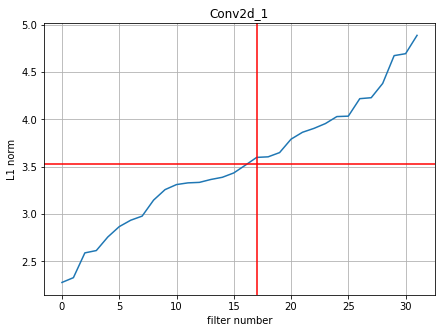

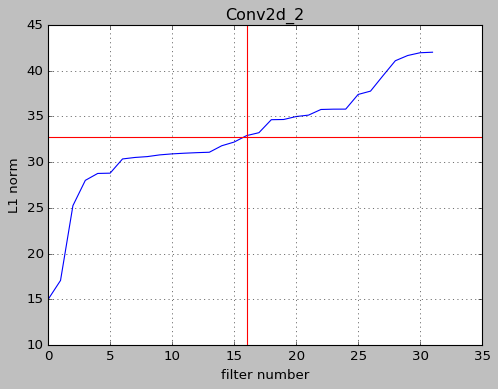

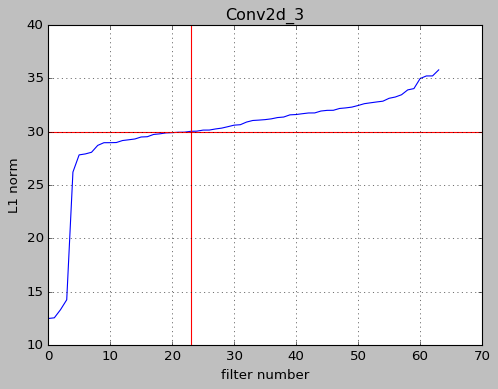

In [8]:
 my_in_conv_layers_get_L1_norms_sorted_indices_and_values(my_model,True)

In [9]:
def my_get_prune_filter_indices(model):
    layer_wise_filter_sorted_indices,layer_wise_filter_sorted_values = my_in_conv_layers_get_L1_norms_sorted_indices_and_values(model,False)
    all_conv_layers = my_get_all_conv_layers(model)
    thresh_hold_means = list()
    for i in range(len(all_conv_layers)):
        thresh_hold_means.append(np.mean(np.array(layer_wise_filter_sorted_values[i])))
    prune_filter_indices = list()
    for i in range(len(all_conv_layers)):
        for j in range(len(layer_wise_filter_sorted_values[i])):
            if(thresh_hold_means[i] < layer_wise_filter_sorted_values[i][j]):
                prune_filter_indices.append(j)
                break
    return prune_filter_indices
prune_filter_indices = my_get_prune_filter_indices(my_model)
prune_filter_indices

[17, 16, 23]

In [0]:
def my_delete_filters(model):
    layer_wise_filter_sorted_indices,layer_wise_filter_sorted_values = my_in_conv_layers_get_L1_norms_sorted_indices_and_values(model,False)
    prune_filter_indices = my_get_prune_filter_indices(model)
    surgeon = Surgeon(my_model)
    for index,value in enumerate(all_conv_layers):
        surgeon.add_job('delete_channels',model.layers[value],channels = layer_wise_filter_sorted_indices[index][0:prune_filter_indices[index]])
    model_new = surgeon.operate()
    return model_new


In [21]:
# Run this cell if you don't have the weights saved
model_new = my_delete_filters(my_model)
model_new.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model_new.save('drive/My Drive/ColabNotebooks/just_after_pruning.h5')

Deleting 17/32 channels from layer: conv2d_1
Deleting 16/32 channels from layer: conv2d_2
Deleting 23/64 channels from layer: conv2d_3


In [12]:
model_new = load_model('drive/My Drive/ColabNotebooks/just_after_pruning.h5')
model_new.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1_input (InputLayer)  (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 15)        420       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 15)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 16)        2176      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 16)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 41)          5945      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 2, 2, 41)          0   

In [13]:



score_train = model_new.evaluate(x_train,y_train) 

print('Accuracy on the Train Images: ', score_train[1])

score_test = model_new.evaluate(x_test, y_test)

print('Accuracy on the Test Images: ', score_test[1])


50000/50000 [==============================] - 19s 387us/step
Accuracy on the Train Images:  0.17252
10000/10000 [==============================] - 4s 373us/step
Accuracy on the Test Images:  0.1701


In [24]:
# Run this cell if you don't have the weights saved
model_new.fit(x_train, y_train, batch_size=32, epochs=10, verbose=1, validation_split=0.2, shuffle=True)
model_new.save('drive/My Drive/Colab Notebooks/after_training_pruned_model.h5')

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 36s 902us/step - loss: 1.1570 - acc: 0.5925 - val_loss: 1.0873 - val_acc: 0.6232
Epoch 2/10
40000/40000 [==============================] - 35s 886us/step - loss: 0.9958 - acc: 0.6518 - val_loss: 1.0190 - val_acc: 0.6506
Epoch 3/10
40000/40000 [==============================] - 36s 892us/step - loss: 0.9462 - acc: 0.6711 - val_loss: 1.0101 - val_acc: 0.6539
Epoch 4/10
40000/40000 [==============================] - 36s 893us/step - loss: 0.9153 - acc: 0.6816 - val_loss: 0.9786 - val_acc: 0.6649
Epoch 5/10
40000/40000 [==============================] - 36s 894us/step - loss: 0.8905 - acc: 0.6904 - val_loss: 0.9559 - val_acc: 0.6733
Epoch 6/10
40000/40000 [==============================] - 36s 911us/step - loss: 0.8712 - acc: 0.6981 - val_loss: 0.9667 - val_acc: 0.6767
Epoch 7/10
40000/40000 [==============================] - 36s 912us/step - loss: 0.8556 - acc: 0.7036 - val_loss: 0.

In [14]:
model_new = load_model('drive/My Drive/ColabNotebooks/after_train_pruning.h5')

score_train = model_new.evaluate(x_train,y_train) 

print('Accuracy on the Train Images: ', score_train[1])

score_test = model_new.evaluate(x_test, y_test)

print('Accuracy on the Test Images: ', score_test[1])



50000/50000 [==============================] - 21s 416us/step
Accuracy on the Train Images:  0.74376
10000/10000 [==============================] - 4s 418us/step
Accuracy on the Test Images:  0.6894
